In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import jax.numpy as jnp
from jax import random, jit, vmap
from sgmcmcjax.kernels import build_sgld_kernel, build_sghmc_kernel, build_sgnht_kernel
from sgmcmcjax.kernels import build_sgldCV_kernel, build_sghmcCV_kernel, build_sgnhtCV_kernel
from sgmcmcjax.util import build_grad_log_post

from sgmcmcjax.optimizer import build_adam_optimizer

import context
from models.logistic_regression.logistic_regression_model import gen_data, loglikelihood, logprior, logloss_samples

from tuning.gridsearch import run_gridsearch
from tuning.ksd import imq_KSD
from tuning.gridsearch import run_gridsearch_time_budget

# Logistic regression: hyperparameter tuning

Run gridsearch using KSD as the metric

In [2]:


key = random.PRNGKey(42)
dim = 10
# Ndata = 100_000
Ndata = 1_000_000

theta_true, X, y_data = gen_data(key, dim, Ndata)

# testing and training data
num_train = int(Ndata*0.8)

X_train = X[:num_train]
X_test = X[num_train:]

y_train = y_data[:num_train]
y_test = y_data[num_train:]
print(X_train.shape, X_test.shape)
data = (X_train, y_train)


generating data, with N=1,000,000 and dim=10
(800000, 10) (200000, 10)


In [3]:
grad_log_post_fb = build_grad_log_post(loglikelihood, logprior, data)

def grad_lp_LR_fb(theta):
    return grad_log_post_fb(theta, X_train, y_train)

batch_grad_lp_LR_fb = jit(vmap(grad_lp_LR_fb))

# @jit
# def get_fb_grads(samples):
#     array_samples = Ω
#     mygrads = batch_grad_lp_LR_fb(jnp.array(samples))
#     return array_samples, mygrads

In [4]:
Niters = 5000
batch_size = int(0.01*X_train.shape[0])

# error_fn = lambda x: logloss_samples(x, X_test, y_test)


def error_fn(x):
    thin = 10
    mysams = jnp.array(x[::thin])
    mygrads = batch_grad_lp_LR_fb(mysams)
    return imq_KSD(mysams, mygrads)

key = random.PRNGKey(0)
key, subkey = random.split(key)
params_IC = 0.2*random.normal(subkey, shape=theta_true.shape) + theta_true

# get MAP
run_adam = build_adam_optimizer(1e-2, loglikelihood, logprior, data, batch_size)
centering_value, logpost_array = run_adam(key, Niters, jnp.zeros(dim))

logdt_range = -jnp.arange(1., 8., 0.5) 

batch_size_range = [int(10**(-elem)*X_train.shape[0]) for elem in range(0, 4)]

print(batch_size_range)

[800000, 80000, 8000, 800]


## grid search

- sgld
- sgldCV
- sghmc
- sghmcCV
- sgnht
- sgnhtCV

In [5]:
time_budget = 1.

Running gridsearch for batch_size, dt
Number of grid points: 56
{'batch_size': 800000, 'dt': 0.1}
{'batch_size': 800000, 'dt': 0.031622775}
{'batch_size': 800000, 'dt': 0.01}
{'batch_size': 800000, 'dt': 0.0031622776}
{'batch_size': 800000, 'dt': 0.001}
{'batch_size': 800000, 'dt': 0.00031622776}
{'batch_size': 800000, 'dt': 1e-04}
{'batch_size': 800000, 'dt': 3.1622778e-05}
{'batch_size': 800000, 'dt': 1e-05}
{'batch_size': 800000, 'dt': 3.1622776e-06}
{'batch_size': 800000, 'dt': 1e-06}
{'batch_size': 800000, 'dt': 3.1622776e-07}
{'batch_size': 800000, 'dt': 1e-07}
{'batch_size': 800000, 'dt': 3.1622776e-08}
{'batch_size': 80000, 'dt': 0.1}
{'batch_size': 80000, 'dt': 0.031622775}
{'batch_size': 80000, 'dt': 0.01}
{'batch_size': 80000, 'dt': 0.0031622776}
{'batch_size': 80000, 'dt': 0.001}
{'batch_size': 80000, 'dt': 0.00031622776}
{'batch_size': 80000, 'dt': 1e-04}
{'batch_size': 80000, 'dt': 3.1622778e-05}
{'batch_size': 80000, 'dt': 1e-05}
{'batch_size': 80000, 'dt': 3.1622776e-06

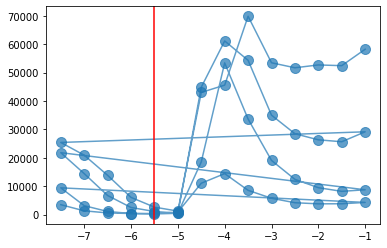

In [9]:
build_kernel = lambda dt, batch_size: build_sgld_kernel(dt, loglikelihood, logprior, data, batch_size)

grid_params = {'log_dt': logdt_range,
              'batch_size': batch_size_range
              }
list_hyperparams, ll_list = run_gridsearch_time_budget(key, build_kernel, error_fn, time_budget, params_IC, grid_params)

log_dt_grid = [np.log10(elem['dt']) for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.nanargmin(ll_list)], c='r')

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")




Running gridsearch for batch_size, dt
Number of grid points: 56
{'batch_size': 800000, 'dt': 0.1}
{'batch_size': 800000, 'dt': 0.031622775}
{'batch_size': 800000, 'dt': 0.01}
{'batch_size': 800000, 'dt': 0.0031622776}
{'batch_size': 800000, 'dt': 0.001}
{'batch_size': 800000, 'dt': 0.00031622776}
{'batch_size': 800000, 'dt': 1e-04}
{'batch_size': 800000, 'dt': 3.1622778e-05}
{'batch_size': 800000, 'dt': 1e-05}
{'batch_size': 800000, 'dt': 3.1622776e-06}
{'batch_size': 800000, 'dt': 1e-06}
{'batch_size': 800000, 'dt': 3.1622776e-07}
{'batch_size': 800000, 'dt': 1e-07}
{'batch_size': 800000, 'dt': 3.1622776e-08}
{'batch_size': 80000, 'dt': 0.1}
{'batch_size': 80000, 'dt': 0.031622775}
{'batch_size': 80000, 'dt': 0.01}
{'batch_size': 80000, 'dt': 0.0031622776}
{'batch_size': 80000, 'dt': 0.001}
{'batch_size': 80000, 'dt': 0.00031622776}
{'batch_size': 80000, 'dt': 1e-04}
{'batch_size': 80000, 'dt': 3.1622778e-05}
{'batch_size': 80000, 'dt': 1e-05}
{'batch_size': 80000, 'dt': 3.1622776e-06

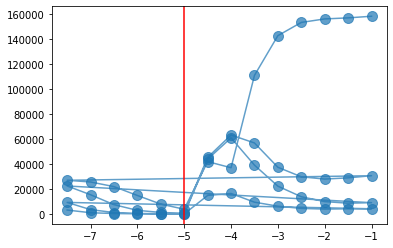

In [11]:
build_kernel = lambda dt, batch_size: build_sgldCV_kernel(dt, loglikelihood, logprior, data, batch_size, centering_value)

grid_params = {'log_dt': logdt_range,
              'batch_size': batch_size_range
              }
list_hyperparams, ll_list = run_gridsearch_time_budget(key, build_kernel, error_fn, time_budget, params_IC, grid_params)

log_dt_grid = [np.log10(elem['dt']) for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.nanargmin(ll_list)], c='r')

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")

In [12]:
build_kernel = lambda dt, L, batch_size: build_sghmc_kernel(dt, L, loglikelihood, logprior, data, batch_size)

grid_params = {'log_dt': logdt_range, "L": [5,10],
              'batch_size': batch_size_range
              }
list_hyperparams, ll_list = run_gridsearch_time_budget(key, build_kernel, error_fn, time_budget, params_IC, grid_params)

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")

Running gridsearch for L, batch_size, dt
Number of grid points: 112
{'L': 5, 'batch_size': 800000, 'dt': 0.1}
{'L': 5, 'batch_size': 800000, 'dt': 0.031622775}
{'L': 5, 'batch_size': 800000, 'dt': 0.01}
{'L': 5, 'batch_size': 800000, 'dt': 0.0031622776}
{'L': 5, 'batch_size': 800000, 'dt': 0.001}
{'L': 5, 'batch_size': 800000, 'dt': 0.00031622776}
{'L': 5, 'batch_size': 800000, 'dt': 1e-04}
{'L': 5, 'batch_size': 800000, 'dt': 3.1622778e-05}
{'L': 5, 'batch_size': 800000, 'dt': 1e-05}
{'L': 5, 'batch_size': 800000, 'dt': 3.1622776e-06}
{'L': 5, 'batch_size': 800000, 'dt': 1e-06}
{'L': 5, 'batch_size': 800000, 'dt': 3.1622776e-07}
{'L': 5, 'batch_size': 800000, 'dt': 1e-07}
{'L': 5, 'batch_size': 800000, 'dt': 3.1622776e-08}
{'L': 5, 'batch_size': 80000, 'dt': 0.1}
{'L': 5, 'batch_size': 80000, 'dt': 0.031622775}
{'L': 5, 'batch_size': 80000, 'dt': 0.01}
{'L': 5, 'batch_size': 80000, 'dt': 0.0031622776}
{'L': 5, 'batch_size': 80000, 'dt': 0.001}
{'L': 5, 'batch_size': 80000, 'dt': 0.000

In [13]:
build_kernel = lambda dt, L, batch_size: build_sghmcCV_kernel(dt, L, loglikelihood, logprior, data, batch_size, centering_value)

grid_params = {'log_dt': logdt_range, "L": [5,10], 'batch_size': batch_size_range}
list_hyperparams, ll_list = run_gridsearch_time_budget(key, build_kernel, error_fn, time_budget, params_IC, grid_params)

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")

Running gridsearch for L, batch_size, dt
Number of grid points: 112
{'L': 5, 'batch_size': 800000, 'dt': 0.1}
{'L': 5, 'batch_size': 800000, 'dt': 0.031622775}
{'L': 5, 'batch_size': 800000, 'dt': 0.01}
{'L': 5, 'batch_size': 800000, 'dt': 0.0031622776}
{'L': 5, 'batch_size': 800000, 'dt': 0.001}
{'L': 5, 'batch_size': 800000, 'dt': 0.00031622776}
{'L': 5, 'batch_size': 800000, 'dt': 1e-04}
{'L': 5, 'batch_size': 800000, 'dt': 3.1622778e-05}
{'L': 5, 'batch_size': 800000, 'dt': 1e-05}
{'L': 5, 'batch_size': 800000, 'dt': 3.1622776e-06}
{'L': 5, 'batch_size': 800000, 'dt': 1e-06}
{'L': 5, 'batch_size': 800000, 'dt': 3.1622776e-07}
{'L': 5, 'batch_size': 800000, 'dt': 1e-07}
{'L': 5, 'batch_size': 800000, 'dt': 3.1622776e-08}
{'L': 5, 'batch_size': 80000, 'dt': 0.1}
{'L': 5, 'batch_size': 80000, 'dt': 0.031622775}
{'L': 5, 'batch_size': 80000, 'dt': 0.01}
{'L': 5, 'batch_size': 80000, 'dt': 0.0031622776}
{'L': 5, 'batch_size': 80000, 'dt': 0.001}
{'L': 5, 'batch_size': 80000, 'dt': 0.000

Running gridsearch for batch_size, dt
Number of grid points: 56
{'batch_size': 800000, 'dt': 0.1}
{'batch_size': 800000, 'dt': 0.031622775}
{'batch_size': 800000, 'dt': 0.01}
{'batch_size': 800000, 'dt': 0.0031622776}
{'batch_size': 800000, 'dt': 0.001}
{'batch_size': 800000, 'dt': 0.00031622776}
{'batch_size': 800000, 'dt': 1e-04}
{'batch_size': 800000, 'dt': 3.1622778e-05}
{'batch_size': 800000, 'dt': 1e-05}
{'batch_size': 800000, 'dt': 3.1622776e-06}
{'batch_size': 800000, 'dt': 1e-06}
{'batch_size': 800000, 'dt': 3.1622776e-07}
{'batch_size': 800000, 'dt': 1e-07}
{'batch_size': 800000, 'dt': 3.1622776e-08}
{'batch_size': 80000, 'dt': 0.1}
{'batch_size': 80000, 'dt': 0.031622775}
{'batch_size': 80000, 'dt': 0.01}
{'batch_size': 80000, 'dt': 0.0031622776}
{'batch_size': 80000, 'dt': 0.001}
{'batch_size': 80000, 'dt': 0.00031622776}
{'batch_size': 80000, 'dt': 1e-04}
{'batch_size': 80000, 'dt': 3.1622778e-05}
{'batch_size': 80000, 'dt': 1e-05}
{'batch_size': 80000, 'dt': 3.1622776e-06

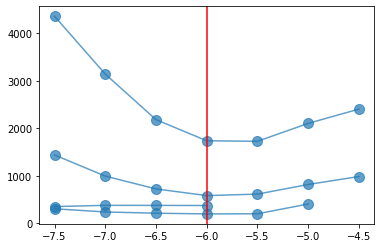

In [14]:
build_kernel = lambda dt, batch_size: build_sgnht_kernel(dt, loglikelihood, logprior, data, batch_size)

grid_params = {'log_dt': logdt_range, 'batch_size': batch_size_range}
list_hyperparams, ll_list = run_gridsearch_time_budget(key, build_kernel, error_fn, time_budget, params_IC, grid_params)

log_dt_grid = [np.log10(elem['dt']) for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.nanargmin(ll_list)], c='r')

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")

Running gridsearch for batch_size, dt
Number of grid points: 56
{'batch_size': 800000, 'dt': 0.1}
{'batch_size': 800000, 'dt': 0.031622775}
{'batch_size': 800000, 'dt': 0.01}
{'batch_size': 800000, 'dt': 0.0031622776}
{'batch_size': 800000, 'dt': 0.001}
{'batch_size': 800000, 'dt': 0.00031622776}
{'batch_size': 800000, 'dt': 1e-04}
{'batch_size': 800000, 'dt': 3.1622778e-05}
{'batch_size': 800000, 'dt': 1e-05}
{'batch_size': 800000, 'dt': 3.1622776e-06}
{'batch_size': 800000, 'dt': 1e-06}
{'batch_size': 800000, 'dt': 3.1622776e-07}
{'batch_size': 800000, 'dt': 1e-07}
{'batch_size': 800000, 'dt': 3.1622776e-08}
{'batch_size': 80000, 'dt': 0.1}
{'batch_size': 80000, 'dt': 0.031622775}
{'batch_size': 80000, 'dt': 0.01}
{'batch_size': 80000, 'dt': 0.0031622776}
{'batch_size': 80000, 'dt': 0.001}
{'batch_size': 80000, 'dt': 0.00031622776}
{'batch_size': 80000, 'dt': 1e-04}
{'batch_size': 80000, 'dt': 3.1622778e-05}
{'batch_size': 80000, 'dt': 1e-05}
{'batch_size': 80000, 'dt': 3.1622776e-06

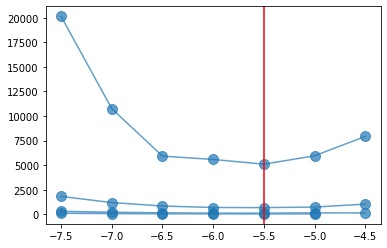

In [15]:
build_kernel = lambda dt, batch_size: build_sgnhtCV_kernel(dt, loglikelihood, logprior, data, batch_size, centering_value)

grid_params = {'log_dt': logdt_range, 'batch_size': batch_size_range}
list_hyperparams, ll_list = run_gridsearch_time_budget(key, build_kernel, error_fn, time_budget, params_IC, grid_params)

log_dt_grid = [np.log10(elem['dt']) for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.nanargmin(ll_list)], c='r')

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")